# Primary Health Care Accessibility in Ontario

In [1]:
#importing all necessary libraries for data analysis and visualization

import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import geopandas

## 1. Data Inspection and Cleaning 

In [4]:
#source data downloaded from:https://data.ontario.ca/dataset/family-health-team-fht-locations

# data text file loaded in pandas and inspected to identify significant attribute for our analysis 
url = 'Ministry_of_Health_Service_Provider_Locations.csv'
location_data = pd.read_csv(url, sep = ',',  encoding='latin-1')
location_data.info()
location_data.drop(['FRENCH_NAME', 'FRENCH_NAME_ALT', 'ENGLISH_NAME_ALT'], axis = 1)
location_data['SERVICE_TYPE'].unique()

#Service Type re-cateegorized to identify group of Primary Care Provider services:
location_data['NEW_SERVICE_TYPE'] = location_data['SERVICE_TYPE']
location_data.loc[location_data['SERVICE_TYPE'].str.contains('Family Health Team|Nurse Practitioner-Led Clinic|Indigenous Primary Health Care Organization|Integrated Community Health Services Centre|Nursing Station'), 'NEW_SERVICE_TYPE'] = 'Primary Care Provider'
location_data['NEW_SERVICE_TYPE'].unique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11749 entries, 0 to 11748
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ï»¿X                        11749 non-null  float64
 1   Y                           11749 non-null  float64
 2   OGF_ID                      11749 non-null  int64  
 3   MOH_SERVICE_PROVIDER_IDENT  11749 non-null  object 
 4   SERVICE_TYPE                11749 non-null  object 
 5   SERVICE_TYPE_DETAIL         9976 non-null   object 
 6   ENGLISH_NAME                11749 non-null  object 
 7   FRENCH_NAME                 88 non-null     object 
 8   ENGLISH_NAME_ALT            916 non-null    object 
 9   FRENCH_NAME_ALT             4 non-null      object 
 10  ADDRESS_LINE_1              11749 non-null  object 
 11  ADDRESS_LINE_2              2813 non-null   object 
 12  ADDRESS_DESCRIPTOR          2173 non-null   object 
 13  COMMUNITY                   117

array(['Licensed Lab and Specimen Collection Centre Locations',
       'Licenced Retirement Home', 'Pharmacy', 'Long-Term Care Home',
       'Community Support Services', 'Primary Care Provider',
       'Mental Health and Addiction Organization',
       'HIV/AIDS and Hep C Programs', 'Seniors Active Living Centre',
       'Hospital', "Children's Treatment Centre", 'Midwifery Clinic',
       'Public Health Unit Office Locations', 'Community Health Centre'],
      dtype=object)

In [6]:
# Mainly : primary care provider density: count/km2 for regional can be calculated 
# Q1. Rural areas vs highly populated cities, type of primary care provider services offered 
# Q2. primary care provider: km2/population identification to understand the accessibility by the population around the clinics
# A. Is the primary care provider serving a population size that is an outlier from provincial standards measured by the distance from any other provider 
# B. Is the primary care provider, nearest provider to a population centre which will be considered inaccessable; i.e. greater 30 min commute time especially for small towns perhaps in northern ontario 


In [8]:
#source data : https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=9810001901
census_data = pd.read_csv('population count per fsc.csv', sep = ',', skiprows = 11, skipfooter = 8, names = ['forward sortation area', 'population_2021', 'Total private dwelling_2021', 'private dwelling by usual resident_2021'], engine =  'python')
census_data.info()
location_data.info()
location_data = location_data.rename(columns = {'ï»¿X' :'X'})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 4 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   forward sortation area                   1646 non-null   object
 1   population_2021                          1646 non-null   object
 2   Total private dwelling_2021              1646 non-null   object
 3   private dwelling by usual resident_2021  1646 non-null   object
dtypes: object(4)
memory usage: 51.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11749 entries, 0 to 11748
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ï»¿X                        11749 non-null  float64
 1   Y                           11749 non-null  float64
 2   OGF_ID                      11749 non-null  int64  
 3   MOH_SERVICE_PROVIDER_IDENT  11749 non-nu

## 2. Data Preparation

In [11]:
#create FSC column and match the FSC values from population dataset to combined corresponding population that the clinics located in. 
location_data['FSC'] = location_data['POSTAL_CODE'].str[:3]
population_fsc = census_data.drop(['Total private dwelling_2021', 'private dwelling by usual resident_2021'], axis =1)
population_fsc.set_index('forward sortation area', inplace = True)
population_fsc_dict = population_fsc.to_dict()

location_data['matched_FSC'] = location_data['FSC'].apply(lambda x: population_fsc_dict['population_2021'].get(x))
location_data['population'] = location_data['matched_FSC'].str.split(',').str.join('')
location_data['population'] = pd.to_numeric(location_data['population'])

#removing columns that ae not significant to our analysis such as goverment/business identifier columns, and name specifier columns as our analysis focuses on Ontario, french name might not be necessary and has lots of missing information.
location_data = location_data.drop(['OGF_ID', 'MOH_SERVICE_PROVIDER_IDENT','FRENCH_NAME','FRENCH_NAME_ALT', 'ENGLISH_NAME_ALT', 'matched_FSC'], axis = 1)

#narrowing down our dataset to only cover the primary care providers which was defined in the data inspection and cleaning section
primary_care_provider = location_data.loc[(location_data['NEW_SERVICE_TYPE'] == 'Primary Care Provider')]


In [47]:
# Filtering data based on Forward Sortation Codes to understand statistical summary of the primary care providers based on the location
fsc_count_df =  primary_care_provider.groupby(['FSC']).agg({'SERVICE_TYPE': 'count'})
fsc_count_dic = fsc_count_df.to_dict()

#creating a new column to identify number of clinics in that specific population area
primary_care_provider.loc[:,'pop_count'] = primary_care_provider.loc[:, 'FSC'].apply(lambda x: fsc_count_dic['SERVICE_TYPE'].get(x))

# if FSC contains '0' in the second character, it is defined as that the area considered to be rural area vs if it is different than zero '0', it is defined as urban area according to the Canada Post designation of FSCs. 
primary_care_provider.loc[:,'population_density_per_are'] = primary_care_provider.loc[:,'FSC'].apply(lambda x: 'rural' if '0' in x else 'urban')


primary_care_provider.loc[:, 'pop_per_clinic'] = primary_care_provider['population']/primary_care_provider['pop_count']

## 3. Data Visulization 

In [70]:
from shapely.geometry import Point

primary_care_provider['coordinates'] =list(zip(primary_care_provider.X, primary_care_provider.Y))
primary_care_provider['coordinates'] = primary_care_provider['coordinates'].apply(Point)

gdf = geopandas.GeoDataFrame(primary_care_provider, geometry = 'coordinates')

/var/folders/rn/k7xw3y792b5bzfp00y6j5z1c0000gn/T/ipykernel_20293/3653125550.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  primary_care_provider['coordinates'] =list(zip(primary_care_provider.X, primary_care_provider.Y))
/var/folders/rn/k7xw3y792b5bzfp00y6j5z1c0000gn/T/ipykernel_20293/3653125550.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  primary_care_provider['coordinates'] = primary_care_provider['coordinates'].apply(Point)


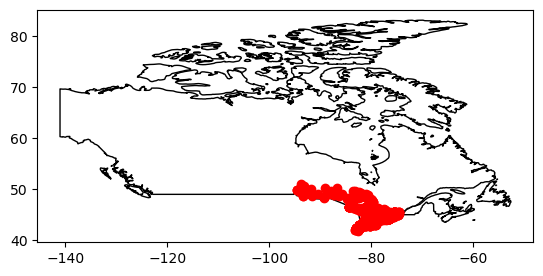

,scalerank,labelrank,sovereignt,sov_a3,adm0_dif,level,type,admin,adm0_a3,geou_dif,...,region_un,subregion,region_wb,name_len,long_len,abbrev_len,tiny,homepart,featureclass,geometry
0,3,5,Netherlands,NL1,1,2,Country,Aruba,ABW,0,...,Americas,Caribbean,Latin America & Caribbean,5,5,5,4,-99,Admin-0 country,"POLYGON ((-69.89912 12.452, -69.8957 12.423, -..."
1,1,3,Afghanistan,AFG,0,2,Sovereign country,Afghanistan,AFG,0,...,Asia,Southern Asia,South Asia,11,11,4,-99,1,Admin-0 country,"POLYGON ((74.89131 37.23164, 74.84023 37.22505..."
2,1,3,Angola,AGO,0,2,Sovereign country,Angola,AGO,0,...,Africa,Middle Africa,Sub-Saharan Africa,6,6,4,-99,1,Admin-0 country,"MULTIPOLYGON (((14.19082 -5.87598, 14.39863 -5..."
3,1,6,United Kingdom,GB1,1,2,Dependency,Anguilla,AIA,0,...,Americas,Caribbean,Latin America & Caribbean,8,8,4,-99,-99,Admin-0 country,"POLYGON ((-63.00122 18.22178, -63.16001 18.171..."
4,1,6,Albania,ALB,0,2,Sovereign country,Albania,ALB,0,...,Europe,Southern Europe,Europe & Central Asia,7,7,4,-99,1,Admin-0 country,"POLYGON ((20.06396 42.54727, 20.10352 42.52466..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,1,4,Samoa,WSM,0,2,Sovereign country,Samoa,WSM,0,...,Oceania,Polynesia,East Asia & Pacific,5,5,5,-99,1,Admin-0 country,"MULTIPOLYGON (((-171.4541 -14.04648, -171.7282..."
237,1,3,Yemen,YEM,0,2,Sovereign country,Yemen,YEM,0,...,Asia,Western Asia,Middle East & North Africa,5,5,4,-99,1,Admin-0 country,"MULTIPOLYGON (((53.76318 12.63682, 53.8248 12...."
238,1,2,South Africa,ZAF,0,2,Sovereign country,South Africa,ZAF,0,...,Africa,Southern Africa,Sub-Saharan Africa,12,12,5,-99,1,Admin-0 country,"MULTIPOLYGON (((37.85693 -46.94424, 37.81396 -..."
239,1,3,Zambia,ZMB,0,2,Sovereign country,Zambia,ZMB,0,...,Africa,Eastern Africa,Sub-Saharan Africa,6,6,6,-99,1,Admin-0 country,"POLYGON ((32.91992 -9.40742, 32.92334 -9.43398..."


In [92]:
world = geopandas.read_file("https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson")
ax = world.loc[(world['admin']) == 'Canada'].plot(color = 'white', edgecolor = 'black')

gdf.plot(ax = ax, color = 'red')

plt.show()

world

In [ ]:
world.loc[(world['